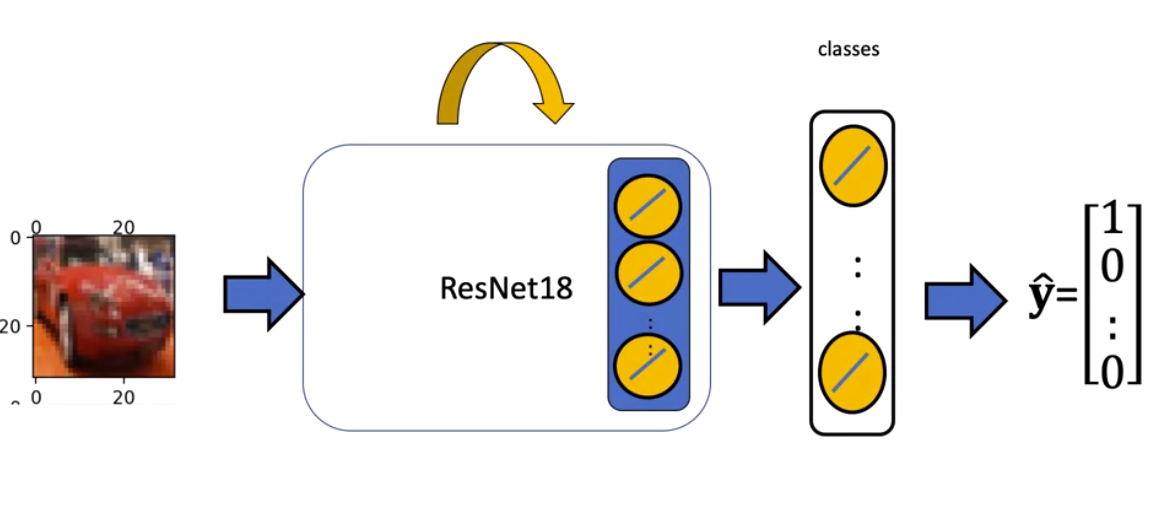

+ Học lai mô hình Resnet18, chỉ thay thế tầng đầu ra cuối cùng bằng tầng đầu ra của mình.  
+ Chỉ cập nhập trọng số cho tầng đầu ra của mình thêm vào, còn các tầng ở trước đó thì giữ nguyên không cập nhập gì.  
+ Mỗi **pretrained Model đều yêu cầu 1 kích thước, định dạng đầu vào cụ thể.** Vậy lên cần tìm hiểu kĩ mô hình pretrained có dữ liệu đầu vào ntn.  

+ Khi train thì phải gọi hàm model.train(), khi suy diễn thì phải gọi hàm model.eval()



In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
# Set GPU for Training
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
# Resnet18 yêu cầu đầu vào là ảnh 224x224, đầu vào cần được chuẩn hóa về mean, std như bên dưới
model = models.resnet18(pretrained=True)
model.to(device)          # use GPU
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean, std)])

train_dataset = dataset.CIFAR10(root='./data', train=True, download=True, transform=transform)
valid_dataset = dataset.CIFAR10(root='./data', download=True, transform=transform)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Set requires_grad = Fasle để ko cập nhập trọng số cho pretrained model. Nó sẽ ko tính đạo hàm cho các Neural của model
for param in model.parameters():
  param.requires_grad = False

# Thay thế  output layer của Resnet bằng bài toán
number_of_last_fc = model.fc.in_features    # Số lượng đầu vào của tầng đầu ra
model.fc = nn.Linear(number_of_last_fc, 10)
criterion = nn.CrossEntropyLoss()

In [5]:
# Chi cap nhap cho cac Neural co requires_grad=True
optimizer = optim.Adam([parameteres for parameteres in model.parameters() if parameteres.requires_grad], lr=0.0001)

In [6]:
trainloader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
validloader = DataLoader(dataset=valid_dataset, batch_size=1000, shuffle=False)

In [7]:
COST = []
ACC = []
def training(model, epochs, optimizer):
    for epoch in range(epochs):
      total_loss = 0
      for x,y in trainloader:
        model.train()
        x,y = x.to(device), y.to(device)
        yhat = model(x)
        loss = criterion(yhat, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      COST.append(np.mean(total_loss))


      correct = 0
      for x,y in validloader:
        model.eval()
        x = x.to(device)
        z = model(x)
        _,label = torch.max(z, 1)
        correct += (label==y).sum().item()
      ACC.append(correct/len(valid_dataset))
      print(f'Epochs {epoch}: {correct}')




In [8]:
epochs = 10
training(model, epochs, optimizer)

Epochs 0: 2.4621331691741943
Epochs 0: 4.906867742538452


KeyboardInterrupt: ignored